In [364]:
%matplotlib inline
import numpy as np
import pandas as pd
import requests
import oauth2
from IPython.display import display, HTML

In [365]:
class OauthAuthenticator(object):

    def __init__(self, consumer_key, consumer_secret, token, token_secret):
        self.consumer = oauth2.Consumer(consumer_key, consumer_secret)
        self.token = oauth2.Token(token, token_secret)

    def sign_request(self, url, url_params={}):
        oauth_request = oauth2.Request(
            method="GET",
            url=url,
            parameters=url_params
        )
        oauth_request.update(
            {
                'oauth_nonce': oauth2.generate_nonce(),
                'oauth_timestamp': oauth2.generate_timestamp(),
                'oauth_token': self.token.key,
                'oauth_consumer_key': self.consumer.key
            }
        )
        oauth_request.sign_request(
            oauth2.SignatureMethod_HMAC_SHA1(),
            self.consumer,
            self.token
        )
        return oauth_request.to_url()
    
auth = OauthAuthenticator('consumer-key', 'consumer-secret',
                  'token', 'token-secret')    

# Businesses filtered to landmarks category
url = 'https://api.yelp.com/v2/search?location=San Francisco CA&limit=15&category_filter=landmarks&sort=2'
response = requests.get(auth.sign_request(url))
data = response.json()
df = pd.io.json.json_normalize(data['businesses'])

# Businesses filtered to restaurants/cafes category
url = 'https://api.yelp.com/v2/search?location=San Francisco CA&limit=15&category_filter=restaurants&sort=2'
response = requests.get(auth.sign_request(url))
data = response.json()
df = df.append(pd.io.json.json_normalize(data['businesses']), ignore_index=True)

In [366]:
# filter relevant columns
df = df[["categories", "id", "location.address", "location.city", "name", "rating", "review_count"]]
print df.shape
print df

(30, 7)
                                           categories  \
0     [[Landmarks & Historical Buildings, landmarks]]   
1   [[Landmarks & Historical Buildings, landmarks]...   
2   [[Landmarks & Historical Buildings, landmarks]...   
3     [[Landmarks & Historical Buildings, landmarks]]   
4   [[Landmarks & Historical Buildings, landmarks]...   
5   [[Landmarks & Historical Buildings, landmarks]...   
6   [[Landmarks & Historical Buildings, landmarks]...   
7     [[Landmarks & Historical Buildings, landmarks]]   
8     [[Landmarks & Historical Buildings, landmarks]]   
9     [[Landmarks & Historical Buildings, landmarks]]   
10  [[Landmarks & Historical Buildings, landmarks]...   
11    [[Landmarks & Historical Buildings, landmarks]]   
12  [[Landmarks & Historical Buildings, landmarks]...   
13  [[Landmarks & Historical Buildings, landmarks]...   
14    [[Landmarks & Historical Buildings, landmarks]]   
15  [[American (Traditional), tradamerican], [Cock...   
16  [[Diners, diners], 

In [367]:
# collapse categories
for i in xrange(30):
    row = df.iloc[i]
    category = row['categories'][0][0]
    df.set_value(i, "categories", category)

In [368]:
df1 = df[["name", "rating", "categories"]]
df1 = df1.sort_values(by='rating', ascending=False)
print "Highest rated landmarks, restaurants and places to visit in San Francisco"
display(HTML(df1[:10].to_html(index=False)))


Highest rated landmarks, restaurants and places to visit in San Francisco


name,rating,categories
Hidden Garden Steps,5.0,Landmarks & Historical Buildings
Marin Headlands,5.0,Landmarks & Historical Buildings
The 16th Avenue Tiled Steps,5.0,Landmarks & Historical Buildings
Fresh Catch Poke,5.0,Hawaiian
Starboard SF,5.0,Diners
Fort Point,5.0,Landmarks & Historical Buildings
Fort Funston,5.0,Landmarks & Historical Buildings
Ike's Place,4.5,Sandwiches
Stones Throw,4.5,American (New)
The Codmother Fish and Chips,4.5,British


In [369]:
df2 = df[["name", "review_count"]]
df2 = df2.sort_values(by='review_count', ascending=False)
print "Ten most visited places in San Francisco"
display(HTML(df2[:10].to_html(index=False)))

Ten most visited places in San Francisco


name,review_count
Ike's Place,6919
Gary Danko,4456
Kokkari Estiatorio,3559
The Codmother Fish and Chips,1821
Garaje,940
Twin Peaks,891
Fort Funston,826
Palace Of Fine Arts,718
Stones Throw,595
The Flying Falafel,480


In [370]:
df3 = df[["name", "review_count", "rating", "categories"]]
df3 = df3[df3["review_count"] < df3["review_count"].quantile(.25)].sort_values(by="rating", ascending=False)
# Relatively less seen places/attractions with high ratings
print "Hidden gems in San Francisco"
display(HTML(df3.to_html(index=False)))

Hidden gems in San Francisco


name,review_count,rating,categories
Hidden Garden Steps,25,5.0,Landmarks & Historical Buildings
Starboard SF,21,5.0,Diners
Fresh Catch Poke,17,5.0,Hawaiian
Pier 7,32,4.5,Landmarks & Historical Buildings
Martin Luther King Jr Memorial,28,4.5,Landmarks & Historical Buildings
Eagle's Point,22,4.5,Landmarks & Historical Buildings
Golden Gate Park Windmills,52,4.5,Landmarks & Historical Buildings
Ho's Bootleg Tavern,42,4.5,American (Traditional)


In [371]:
keys = []
vals = []
category_groups = df.groupby("categories")
for name, group in category_groups:
    keys.append(name)
    vals.append(group["rating"].mean())


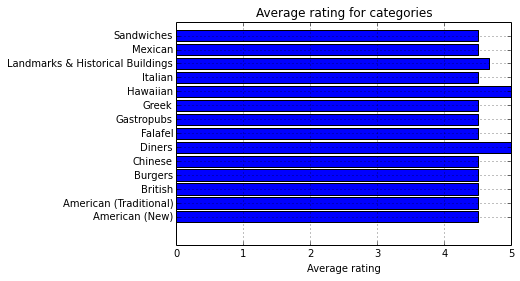

In [372]:
from pylab import *
keycenters = arange(len(keys))
figure(1)
barh(keycenters,vals, align='center')
yticks(keycenters,keys)
xlabel('Average rating')
title("Average rating for categories")
grid(True)